# **Demand Forecasting**

We have 1 year of online item sales data, and will be predicting for the next 3 months.

# Importing Libraries 

In [ ]:
!pipreqsnb /Users/user/Passion8/demand_forecast/store_demand.ipynb

In [458]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import sqlalchemy
import itertools
import chart_studio.plotly  as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
import sqlalchemy
import psycopg2
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [459]:
# To change the default settings for the notebook
YOUR_POSTGRES_PASSWORD = '' 
YOUR_POSTGRES_PORT_NO = 5432 

# Default if you have cloned from repo-main 
host = 'localhost'
database = 'dsa3101' # default db name
user = 'postgres'

In [460]:
# Create a database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{YOUR_POSTGRES_PASSWORD}@{host}:{YOUR_POSTGRES_PORT_NO}/{database}')

In [494]:
def create_df():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            date, product_id, SUM("Quantity") AS sales
        FROM
            online_sales 
        GROUP BY
            date, product_id
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

# Display the DataFrame
train_df = create_df()
train_df.head()

,date,product_id,sales
0,2019-01-25,B08NCKT9FG,2.0
1,2019-09-23,B0B6F7LX4C,3.0
2,2019-02-22,B00N1U9AJS,26.0
3,2019-09-23,B06XMZV7RH,1.0
4,2019-07-10,B08D9NDZ1Y,20.0


In [495]:
# Create a date range for the year 2020, range of 90 days
dates = pd.date_range(start='2020-01-01', end='2020-03-30', freq='D')

# Get all unique product IDs and have every date for each product ID
product_ids = train_df['product_id'].unique()
dates = np.repeat(dates, len(product_ids))

# Create the new DataFrame
test_df = pd.DataFrame({'date': dates, 'product_id': np.tile(product_ids, len(dates)//len(product_ids))})

test_df['sales'] = np.nan

In [463]:
lag_size = (test_df['date'].max().date() - train_df['date'].max().date()).days
print('Max date from train set: %s' % train_df['date'].max().date())
print('Max date from test set: %s' % test_df['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2019-12-31
Max date from test set: 2020-03-30
Forecast lag size 90


### Basic EDA

To explore the time series data first we need to aggregate the sales by day

In [464]:
train = train_df.copy()

In [465]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['product_id', 'date'], as_index=False)['sales'].sum()

### Overall daily sales

In [466]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

### Daily sales by item

In [467]:
item_daily_sales_sc = []
for item in item_daily_sales['product_id'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['product_id'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Product %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

## Trend and Seasonality

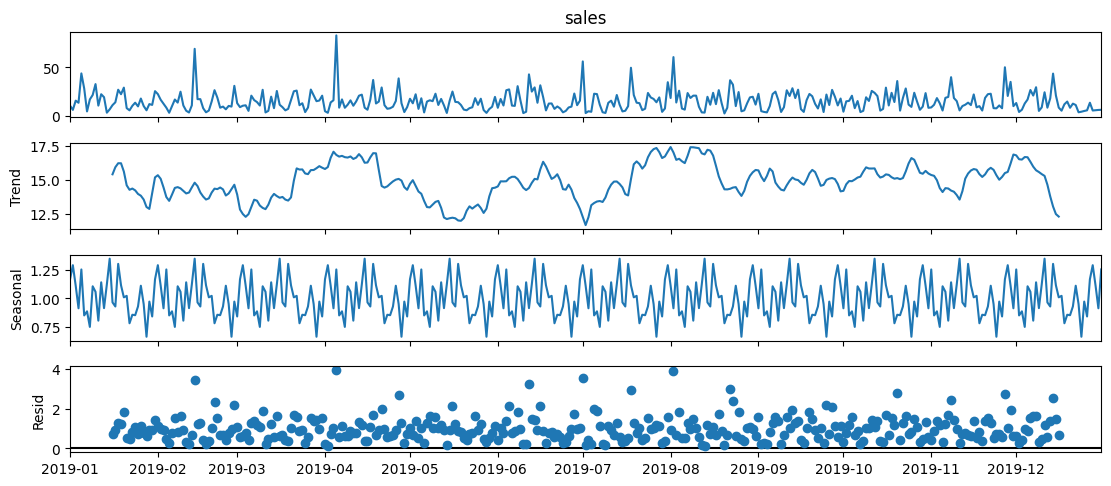

In [468]:
result = seasonal_decompose(train_df.groupby(by='date')['sales'].mean(), model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(12, 5)


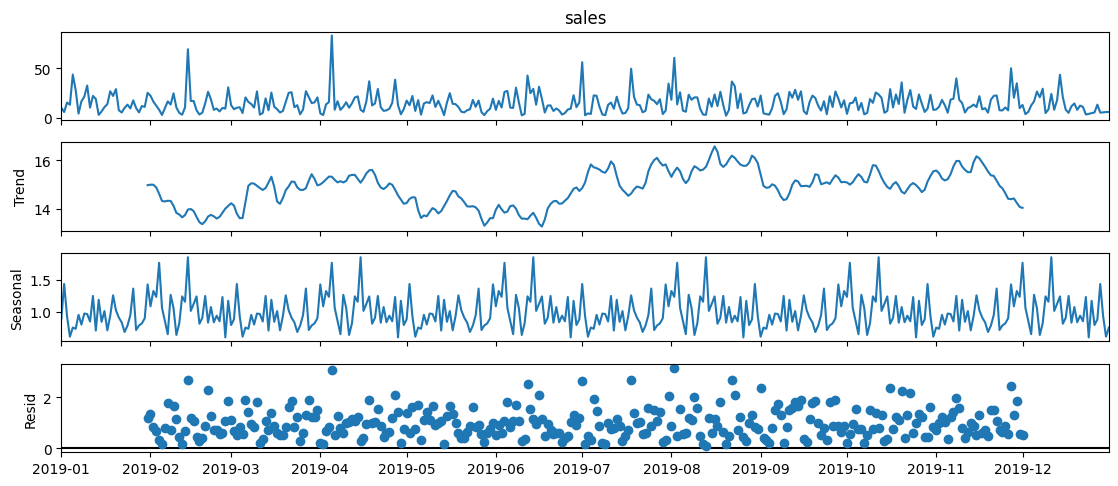

In [470]:
result = seasonal_decompose(train_df.groupby(by='date')['sales'].mean(), model='multiplicative', period=60)
fig = result.plot()
fig.set_size_inches(12, 5)

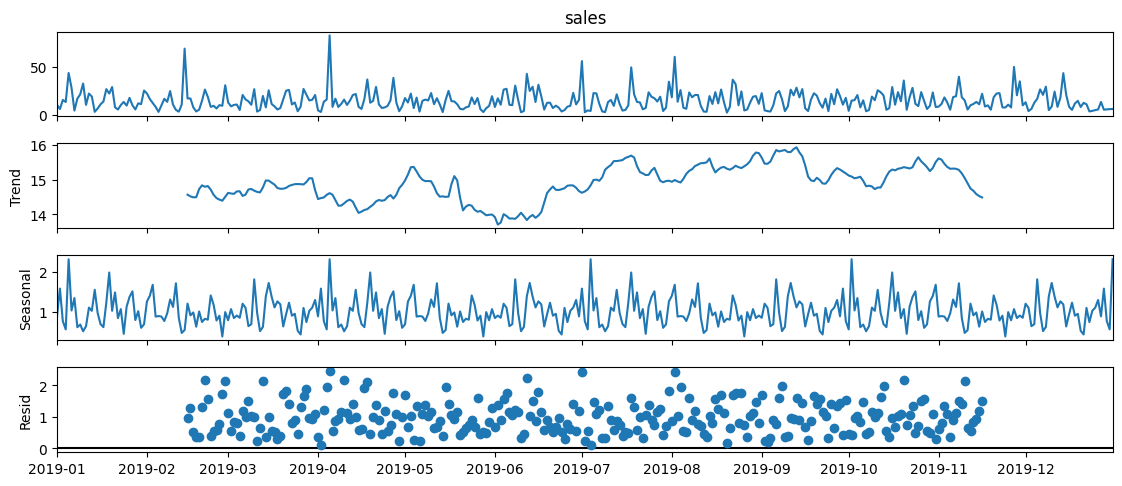

In [89]:
result = seasonal_decompose(train_df.groupby(by='date')['sales'].mean(), model='multiplicative', period=90)
fig = result.plot()
fig.set_size_inches(12, 5)

The data is rather clean and regular, and the patterns of trend and seasonality can be catched using: months and days of the week.

# Exploring Data Analysis

In [496]:
# convert product_id column to number by label encoding
encoder = LabelEncoder()
train_df['product_id'] = encoder.fit_transform(train_df['product_id'])
test_df['product_id'] = encoder.fit_transform(test_df['product_id'])

In [169]:
df = pd.concat([train_df, test_df], axis=0)

In [90]:
print("df dimensions:",df.shape) 
print("Test df dimensions:",test_df.shape)
print("Train df dimensions:",train_df.shape)

df dimensions: (27285, 3)
Test df dimensions: (11970, 3)
Train df dimensions: (15315, 3)


The code calculates the quantiles (percentiles) of the data in the DataFrame 'df' for the specified quantile levels [0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]. It transposes the resulting DataFrame to display the quantiles for each column as rows.

In [91]:
df.select_dtypes(include=['number','datetime']).quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
date,2019-01-01 00:00:00,2019-02-04 00:00:00,2019-06-05 00:00:00,2019-11-07 00:00:00,2020-02-08 00:00:00,2020-03-20 00:00:00,2020-03-28 00:00:00,2020-03-30 00:00:00
sales,1.0,1.0,1.0,3.0,11.0,65.0,204.0,1197.0


In [44]:
df["date"].min()

Timestamp('2019-01-01 00:00:00')

In [168]:
df["date"].max()

Timestamp('2020-03-30 00:00:00')

The code calculates descriptive statistics for the 'sales' column in the DataFrame 'df', including mean, standard deviation, minimum, maximum, and percentiles at the specified quantile levels [0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99].






In [167]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    15315.000000
mean        15.664120
std         46.451661
min          1.000000
10%          1.000000
30%          2.000000
50%          3.000000
70%          8.000000
80%         16.000000
90%         35.000000
95%         65.000000
99%        204.000000
max       1197.000000
Name: sales, dtype: float64

In [33]:
df["product_id"].nunique()

133

The code groups the DataFrame 'df' by "product_id", and then aggregates the "sales" column, calculating the sum, mean, median, and standard deviation of sales for each product in the dataset.






In [18]:
df.groupby(["product_id"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
               sum       mean median        std
product_id                                     
0             44.0   1.833333    1.0   1.307725
1            256.0   5.224490    1.0  24.930123
2           1553.0   6.902222    2.0  14.069320
3             60.0   1.463415    1.0   0.636300
4            282.0   2.256000    1.0   3.883181
...            ...        ...    ...        ...
128          113.0   1.883333    1.0   2.091886
129          113.0   1.883333    1.0   2.091886
130          225.0   4.017857    3.0   3.283518
131          247.0   9.500000    2.0  20.258825
132         2434.0  24.585859   10.0  35.936171

[133 rows x 4 columns]

# Feature Engineering

The code extracts various date-related features from the "date" column of the DataFrame 'df', such as month, day of the month, day of the year, week of the year, day of the week, and year. It also creates new binary features indicating whether the date is a weekend, month start, or month end.






In [172]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

In [97]:
df.head()

,date,product_id,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2019-01-25,65,2.0,1,25,25,4,4,2019,1,0,0
1,2019-09-23,115,3.0,9,23,266,39,0,2019,0,0,0
2,2019-02-22,11,26.0,2,22,53,8,4,2019,1,0,0
3,2019-09-23,22,1.0,9,23,266,39,0,2019,0,0,0
4,2019-07-10,60,20.0,7,10,191,28,2,2019,0,0,0


# Random Noise 

The code defines a function 'random_noise' that takes a DataFrame as input and returns an array of random noise generated from a normal distribution with a scale of 1.6 and the same length as the input DataFrame.






In [173]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features 

The code sorts the DataFrame 'df' in place based on multiple columns, first by 'product_id', and then 'date' in ascending order. The 'head()' function is then used to display the first few rows of the sorted DataFrame.






In [174]:
df.sort_values(by=['product_id', 'date'], axis=0, inplace=True)
df.head()

,date,product_id,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
3955,2019-01-13,0,1.0,1,13,13,2,6,2019,1,0,0
7481,2019-02-21,0,4.0,2,21,52,8,3,2019,0,0,0
11867,2019-02-23,0,1.0,2,23,54,8,5,2019,1,0,0
14955,2019-03-21,0,3.0,3,21,80,12,3,2019,0,0,0
11630,2019-04-05,0,1.0,4,5,95,14,4,2019,1,0,0


The code defines a function 'lag_features' that creates lagged features for the 'sales' column in the DataFrame 'df' by shifting the values by different time intervals specified in 'lags'. The function adds random noise to the shifted values and returns the updated DataFrame. The 'lag_features' function is then called with 'df' and a list of lag intervals to create the lagged features for the specified lags.






In [175]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["product_id"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df = lag_features(df,  [7, 14, 30, 60, 90])

# Rolling Mean Features

The code defines a function 'roll_mean_features' that calculates rolling mean features for the 'sales' column in the DataFrame 'df' using different rolling window sizes specified in 'windows'. The function applies the triangular rolling window with a minimum of 10 periods and adds random noise to the calculated rolling means. The updated DataFrame is then returned. The 'roll_mean_features' function is called with 'df' and a list of rolling window sizes to create the rolling mean features for the specified windows.






In [176]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["product_id"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=min(window,10), win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [7, 14, 30, 60,90])

# Exponentially Weighted Mean Features

The code defines a function 'ewm_features' that calculates exponentially weighted moving average (EWMA) features for the 'sales' column in the DataFrame 'df' using different smoothing factors (alphas) and lag intervals specified in 'alphas' and 'lags', respectively. The function applies the EWMA to the lagged 'sales' data within each group defined by 'product_id'. The updated DataFrame is then returned. The 'ewm_features' function is called with lists of alphas and lags to create the EWMA features for the specified combinations of smoothing factors and lag intervals, and the last few rows of the updated DataFrame are displayed using 'tail()'.






In [177]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["product_id"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
# lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
lags =  [7, 14, 30, 60, 90]

df = ewm_features(df, alphas, lags)
df.head()

,date,product_id,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_30,sales_lag_60,sales_lag_90,sales_roll_mean_7,sales_roll_mean_14,sales_roll_mean_30,sales_roll_mean_60,sales_roll_mean_90,sales_ewm_alpha_099_lag_7,sales_ewm_alpha_099_lag_14,sales_ewm_alpha_099_lag_30,sales_ewm_alpha_099_lag_60,sales_ewm_alpha_099_lag_90,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90
3955,2019-01-13,0,1.0,1,13,13,2,6,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7481,2019-02-21,0,4.0,2,21,52,8,3,2019,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11867,2019-02-23,0,1.0,2,23,54,8,5,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14955,2019-03-21,0,3.0,3,21,80,12,3,2019,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11630,2019-04-05,0,1.0,4,5,95,14,4,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The code performs one-hot encoding on the 'day_of_week' and 'month' columns of the DataFrame 'df', creating binary columns for each unique value in these columns, effectively converting categorical variables into numerical format.






In [178]:
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

The code applies the natural logarithm transformation (logarithm with base e) to the 'sales' column in the DataFrame 'df', using the numpy function 'np.log1p', which handles zero values gracefully by adding 1 before taking the logarithm. This transformation is often used to stabilize the variance and improve the performance of certain models.






In [179]:
df['sales'] = np.log1p(df["sales"].values)

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_lags = df.drop(columns=['date']).dropna()
# Prepare features and target variable
X = df_lags.drop(columns=['sales'])
y = df_lags['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.0201381826844795


The root mse is low so the features created are acceptable.

## LightGBM Model

The code creates two new DataFrames, 'train' and 'val', by filtering rows from the original DataFrame 'df' based on the dates. 'train' contains data before September, 2019, and 'val' contains data between October 1, 2019, and December 1, 2019. The variable 'cols' is defined as a list of column names from 'train' DataFrame, excluding the columns 'date', 'product_id', 'sales', and 'year'.






In [180]:
train = df.loc[(df["date"] < "2019-09-01"), :]

val = df.loc[(df["date"] > "2019-09-01") & (df["date"] < "2019-12-31"), :]

cols = [col for col in train.columns if col not in ['date', "sales", "year"]]

The code creates four new variables: 'Y_train' and 'Y_val' are the target variables containing the 'sales' data for the training and validation sets, respectively. 'X_train' and 'X_val' are the feature matrices containing the selected columns (excluding 'date', 'id', 'sales', and 'year') for the training and validation sets, respectively. The final line displays the shapes of these arrays, indicating the number of rows and columns in each set.






In [181]:
Y_train = train['sales']

X_train = train[cols]

Y_val = val['sales']

X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((11062,), (11062, 66), (4175,), (4175, 66))

## Custom Cost Function

The code defines two functions: 'smape' calculates the Symmetric Mean Absolute Percentage Error (SMAPE) for two arrays of predictions and true target values, while 'lgbm_smape' computes SMAPE for LightGBM predictions by converting them back from log-scale using 'np.expm1' and comparing with the original labels.






In [182]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

The code defines a dictionary 'lgb_params' containing various parameters for the LightGBM model, including the evaluation metric (Mean Absolute Error - 'mae'), number of leaves, learning rate, feature fraction, maximum depth, verbosity, number of boosting rounds, early stopping rounds, . These parameters will be used to configure the LightGBM model for training and evaluation.






In [311]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 2000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [332]:
lgb_params = {'feature_fraction': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'mae', 'num_leaves': 30, 'num_boost_round': 2000
}

The code sets up the LightGBM datasets for training and validation ('lgbtrain' and 'lgbval') with specified features and labels. It then trains the LightGBM model using 'lgb_params' with early stopping based on the validation set, and evaluates the model's performance using SMAPE on the validation set, which is then calculated on the predicted target values ('y_pred_val') and the true target values ('Y_val').






In [333]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape,
                  callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(100)])
                #   early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  
                #  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration) # best iteration is 701

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l1: 0.566373	training

11.9142699832828

The code separates the original DataFrame 'df' into the training set and the test set based on the presence of NaN values in the 'sales' column. It creates 'X_train' and 'X_test' as the feature matrices and 'Y_train' as the target variable containing non-NaN sales data for training.






In [186]:
#Final Model
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

The code sets up LightGBM parameters in the 'lgb_params' dictionary and initializes the LightGBM dataset 'lgbtrain_all' using the entire training data. Then, it trains the LightGBM model on the full training data with 'lgb_params', using the optimal number of boosting rounds obtained from the earlier trained model ('model.best_iteration'). The model is then used to make predictions on the test set, and the results are stored in 'test_preds'.






In [335]:
# lgb_params = {'metric': {'mae'},
#               'num_leaves': 10,
#               'learning_rate': 0.02,
#               'feature_fraction': 0.8,
#               'max_depth': 5,
#               'verbose': 0,
#               'nthread': -1,
#               "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [315]:
Y_train.shape, X_train.shape, X_test.shape, test_preds.shape

((15315,), (15315, 66), (11970, 66), (11970,))

In [328]:
param_grid = {
    'metric': ['mae'],  
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.7, 0.8, 0.9],
    'max_depth': [3, 5, 7]
}

Finding the best parameters for training the lgb model

In [329]:
model = lgb.LGBMRegressor()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

# Results
The predictions and actual sales level will be plotted and shown together in an interactive plot to visualise it.

In [336]:
# convert the predictions back to normal values from log transformed
predictions = np.expm1(test_preds)

forecast = pd.DataFrame({"date":test["date"],
                        "product":test["product_id"],
                        "sales":predictions
                        })

In [348]:
#find the product that has the highest sales
forecast[forecast["sales"]==forecast["sales"].max()]


,date,product,sales
1493,2020-01-12,75,124.787583


<Axes: xlabel='date'>

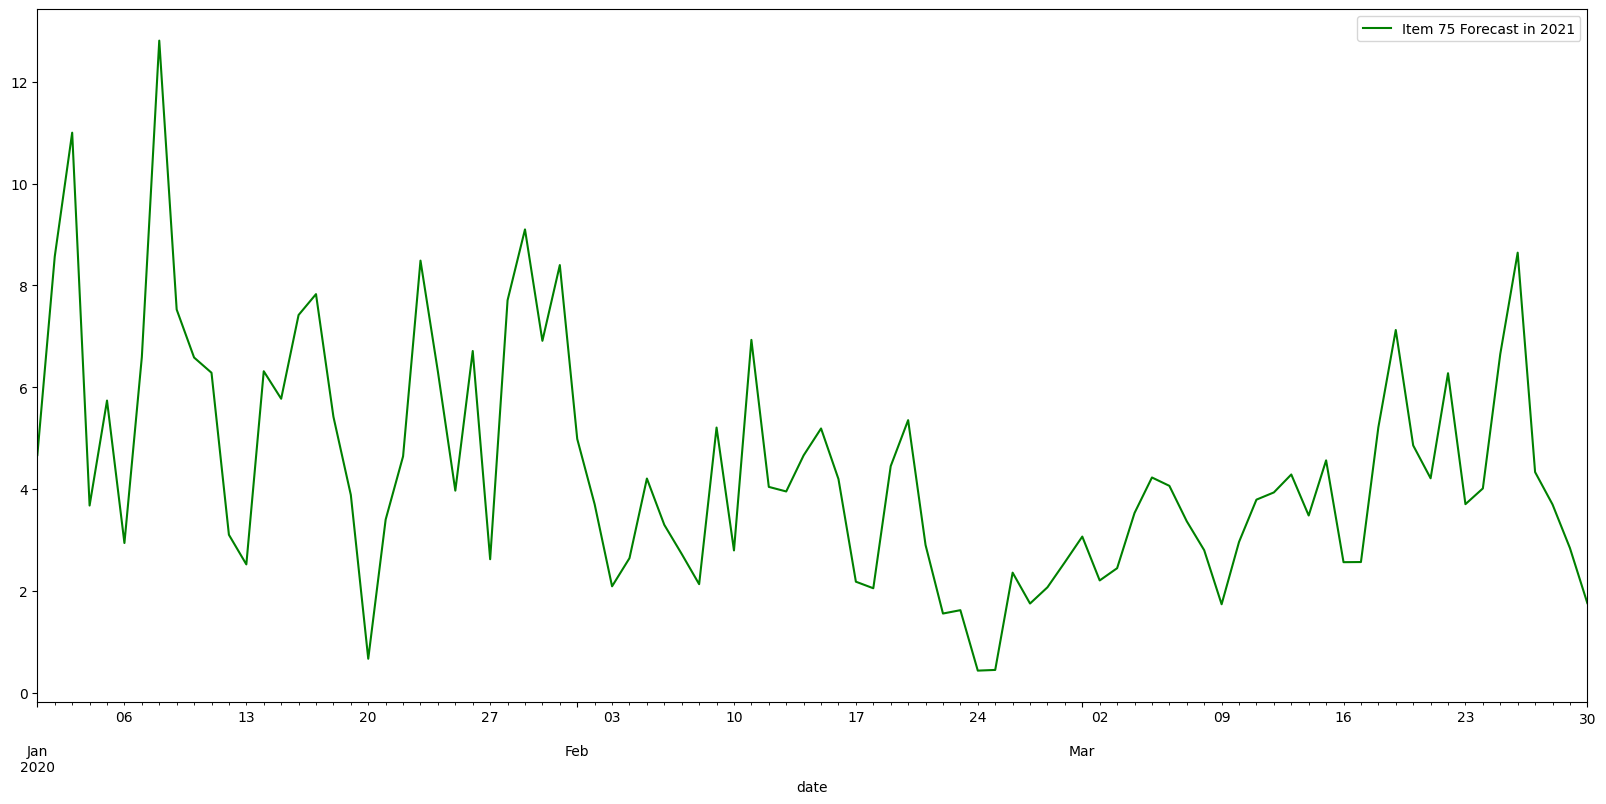

In [361]:
forecast[forecast['product'] == 2].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Item 75 Forecast in 2021")


In [360]:
def forecast_demand(product_id):
    actual = df[(df['product_id']== product_id)]
    # change actual to normal values from log transformed
    actual['sales'] = np.expm1(actual['sales'].values)
    actual['type'] = 'actual'
    forecasted = forecast[(forecast['product'] == product_id)]
    forecasted['type'] = 'forecast'
    product_df = pd.concat([actual,forecasted], axis = 0)
    fig = px.line(product_df, x='date', y='sales', color='type',title=f'Item {encoder.classes_[product_id]} Demand Forecast in 2021')
    fig.show()
    

forecast_demand(2)

In [43]:
# find the product id before encoding
encoder.inverse_transform([75])[0]

'B08XMG618K'

In [444]:
def forecast_demand(product_id):
    actual = df[(df['product_id']== product_id)]
    # change actual to normal values from log transformed
    actual['sales'] = np.expm1(actual['sales'].values)
    actual['type'] = 'actual'
    forecasted = forecast[(forecast['product'] == product_id)]
    forecasted['type'] = 'forecast'
    product_df = pd.concat([actual,forecasted], axis = 0)
    fig = px.line(product_df, x='date', y='sales', color='type',title=f'Item {encoder.classes_[product_id]} Demand Forecast in 2021')
    fig.show()
    

forecast_demand(78)

# Inventory Optimization
Now that we have forecasted the demand for each product, we can use the forecasted demand to calculate the optimal inventory policy for the product.

Finding the optimal inventory policy will help us determine the Reorder Point, Safety Stock, and Economic Order Quantity(EOQ) for the product. These markers will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.

## Re Order Point

The reorder point is the inventory level at which we should reorder more stock. ROP is calculated as the product of the average sales per day and the lead time (also referred to as Lead Time Demand) plus the Safety stock.

The `Lead Time` with regards to the reordering point is the time it takes for a product to be delivered by upstream supply chain manufacturers to the store's warehouse. It is the time between the placement of an order by the store and the receipt of the product.

For the purposes of our analysis we will assume an average upstream `Lead time` of 7 days

In [501]:
# find the top selling product from train_df
top = train_df.groupby('product_id')['sales'].sum().sort_values(ascending=False).head(1).index[0]

# get the product id from train_df before encoding
product_id = encoder.inverse_transform([top])[0]

In [482]:

def find_lead_time_demand(product_id, average_lead_time):
    forecasted = forecast[(forecast['product'] == product_id)]
    average_forecasted_sales = forecasted['sales'].mean() # Extract the average forecasted sales per day from predictions
    lead_time_demand = average_forecasted_sales * average_lead_time
    return round(lead_time_demand,1)

lead_time_demand = find_lead_time_demand(top,7)
print(f"Lead Time Demand: {lead_time_demand}")


Lead Time Demand: 66.5


## Safety Stock
The safety stock is the extra stock that is kept on hand to mitigate the risk of stockouts due to uncertainties in demand and lead time.

Safety Stock = (Maximum Daily Sales × Maximum Lead Time) − Lead Time Demand

Let's also assume that there have been delays from the manufacturer in the past and the maximum lead time is 10 days. That is 3 days later than the average order fulfillment timeline.

In [483]:
# find maximum daily forecasted sales
def find_safety_stock(product_id, average_lead_time):
    forecasted = forecast[(forecast['product'] == product_id)]
    max_daily_forecasted_sales = forecasted['sales'].max()
    max_lead_time = average_lead_time + 3  # 3 days delays in delivery than the average
    lead_time_demand = max_daily_forecasted_sales * average_lead_time
    safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
    return round(safety_stock,1)

safety_stock = find_safety_stock(top,7)
print(f"Safety Stock: {safety_stock}")

Safety Stock: 153.5


## Calculate reorder point

In [484]:
reorder_point = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {reorder_point}")

The Optimal Reorder Point for the Top-selling Product is: 220.0


As indicated by the result, the reorder point for the product number 11 is `220` units, which means that we should reorder more stock when the inventory level reaches `220` units. This will help us ensure that we have enough stock on hand to meet customer demand while minimizing inventory costs.

## Economic Order Quantity (EOQ)
It is used to calculate the optimal order quantity for the top-selling product. The EOQ model helps us determine the optimal order quantity that minimizes the total inventory costs.

Unlike the Reorder Point which is concerned with determining the level of inventory at which a new order should be placed to avoid stockouts, EOQ takes into account the costs of ordering (e.g., setup costs) and the costs, of holding inventory (e.g., storage costs, opportunity costs).

For our analysis, we will assume that the ordering and holding cost is 10% and 30% of the product price respectively since I do not have data on that.

In [506]:
def create_df():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            product_id, actual_price
        FROM
            online_sales 
        JOIN
            products
        USING
            (product_id)
        GROUP BY
            product_id, actual_price
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

# Display the DataFrame
price_df = create_df()
price_df.head()

,product_id,actual_price
0,B08WRWPM22,5.99
1,B09NC2TY11,71.99
2,B00P0R95EA,7.68
3,B00KIE28X0,3.72
4,B09PNR6F8Q,4.79


In [520]:
# Calculate EOD
def calculate_EOD(product_id, index):
    product_price = price_df[price_df['product_id'] == product_id].actual_price.values[0]
    H = 0.10 * product_price
    S = 0.30 * product_price
    D = forecast[(forecast['product'] == index)]['sales'].mean()
    EOQ = round(np.sqrt((2 * D * S) / H))
    return D, H, S, EOQ
    
D, H, S, EOQ = calculate_EOD(product_id,top)
print(f"The Demand Rate is: {D}")
print(f"The Holding Cost is: {H}")
print(f"The Ordering Cost is: {S}")
print(f"The Economic Order Quantity is: {EOQ}")

The Demand Rate is: 9.499330695473114
The Holding Cost is: 1.854
The Ordering Cost is: 5.561999999999999
The Economic Order Quantity is: 8


Based on the EOQ model, the optimal order quantity for the top-selling product is `8` units. This means that we should order `8` units of the product at a time to minimize the total inventory costs. This will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.